# Example: Obtaining results from the eq and profiles objects

Here we will take a look at how to access different results stored (or calculated using methods) in the `eq` and `profiles` objects. 

To do this we first need to run a static forward simulation in the MAST-U-like tokamak using previously saved coil currents to generate our results. Of course, the same methods below can be applied after an inverse solve!

## Static forward simulation

No probe configuration is provided


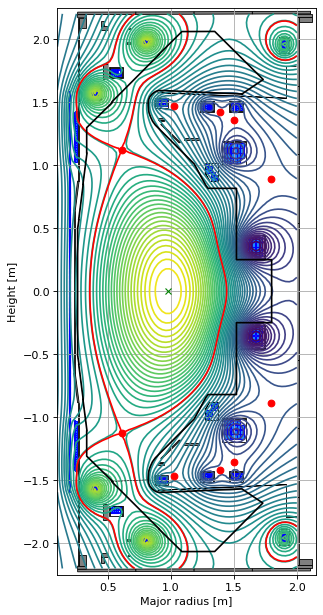

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"


# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak()

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Dashboard of results

It is worth playing around with the fields/methods in the `eq` and `profiles` objects yourself to see which quantities can be calculated from the plasma equilibrium using built-in functionality. Below, we provide a mini dashboard of different quantities and how to generate them. 

If there are certain quantites that you wish to be added that don't exist within FreeGSNKE at the moment, please do submit a feature request to the Github repository.

#### General equillibrium quantites
Here, we display a number of  used equilibrium quantites. 

In [30]:
eq.xpt

array([[ 0.60973289,  1.12220985,  0.03044811],
       [ 0.60973966, -1.12209518,  0.03044185],
       [ 1.02599751,  1.46877527,  0.00398506],
       [ 1.02599672, -1.46876946,  0.0039813 ],
       [ 1.79337924,  0.88629306, -0.01588714],
       [ 1.79335391, -0.88629359, -0.01589041],
       [ 1.39006703,  1.42071303, -0.01821089],
       [ 1.39007074, -1.4207086 , -0.01821375],
       [ 1.50285175,  1.35789805, -0.01960385],
       [ 1.50284812, -1.35789791, -0.01960645]])

In [ ]:
print(rf"Plasma current: {eq.plasmaCurrent()} [A]")
print(rf"Minor radius: {eq.minorRadius()} [m]")
print(rf"Minor radius (geometric): {eq.Rgeometric()} [m]")
print(rf"Minor radius (magnetic): {eq.Rmagnetic()} [m]")
print(rf"Magnetic axis location: {eq.magneticAxis()[0:2]} [m]")
print(rf"Geometric axis location: {eq.geometricAxis()} [m]")
print(rf"Inner and outer mipdplane radii: {eq.innerOuterSeparatrix()} [m]")

Plasma current: 620000.0 [A]
Minor radius: 0.724705579483715 [m]
Minor radius (geometric): 0.9121444163249702 [m]
Minor radius (magnetic): 0.9817055001931039 [m]
Magnetic axis location: [9.81705500e-01 1.01102903e-04] [m]
Geometric axis location: [9.12144416e-01 1.30783568e-04] [m]
Inner and outer mipdplane radii: (0.35760713898188334, 1.443719350657104) [m]


In [ ]:
print(rf"Aspect ratio: {eq.aspectRatio()}")
print(rf"Geometric elongation: {eq.geometricElongation()}")
print(rf"Effective elongation: {eq.effectiveElongation()}")
print(rf"Poloidal beta (method 1): {eq.poloidalBeta()}")
print(rf"Poloidal beta (method 2): {eq.poloidalBeta2()}")
print(rf"Toroidal beta: {eq.toroidalBeta()}")
print(rf"Total plasma beta: {eq.totalBeta()}")
print(rf"Plasma volume: {eq.plasmaVolume()}")

Aspect ratio: 1.2586413602262976
Geometric elongation: 2.0590264295863006
Effective elongation: 1.8232904281414226
Poloidal beta (method 1): 0.19890674480550558
Poloidal beta (method 2): 0.18217157922136293
Toroidal beta: 0.008090952534041492
Total plasma beta: 0.007746883145790787
Plasma volume: 17.241395209926416


In [ ]:
print(fr"Poloidal flux on magnetic axis: {eq.psi_axis} [Webers/2\pi]")
print(fr"Poloidal flux on plasma boundary: {eq.psi_bndry} [Webers/2\pi]")

Poloidal flux on magnetic axis: 0.09721709887963567 [Webers/2\pi]
Poloidal flux on plasma boundary: 0.030448110873181992 [Webers/2\pi]


In [39]:
print(fr"Plasma internal inductance (li1): {eq.internalInductance1()}")
print(fr"Plasma internal inductance (li2): {eq.internalInductance2()}")
print(fr"Plasma internal inductance (li3): {eq.internalInductance3()}")

Plasma internal inductance (li1): 1.6127845433687797
Plasma internal inductance (li2): 1.0429110977480591
Plasma internal inductance (li3): 1.1224445850326144


In [40]:
# extract the plasma core boundary (specify the number of points you want)
eq.separatrix(ntheta=20) 


array([[ 9.81705500e-01,  9.53907340e-01],
       [ 1.22287969e+00,  7.42358943e-01],
       [ 1.34238609e+00,  4.96535340e-01],
       [ 1.38738739e+00,  2.94846247e-01],
       [ 1.42512789e+00,  1.44177772e-01],
       [ 1.44360855e+00,  1.01102903e-04],
       [ 1.42515220e+00, -1.43983464e-01],
       [ 1.38739645e+00, -2.94650628e-01],
       [ 1.34237338e+00, -4.96315650e-01],
       [ 1.22289197e+00, -7.42194540e-01],
       [ 9.81705500e-01, -9.53728064e-01],
       [ 6.19083260e-01, -1.11593540e+00],
       [ 4.65042612e-01, -7.11024355e-01],
       [ 3.95256601e-01, -4.25978963e-01],
       [ 3.65930933e-01, -1.99976182e-01],
       [ 3.57911400e-01,  1.01102903e-04],
       [ 3.65927186e-01,  2.00179606e-01],
       [ 3.95246469e-01,  4.26188530e-01],
       [ 4.65012696e-01,  7.11267737e-01],
       [ 6.17976542e-01,  1.11954373e+00]])

In [41]:
# extract the X points (R, Z, psi)
eq.xpt


array([[ 0.60973289,  1.12220985,  0.03044811],
       [ 0.60973966, -1.12209518,  0.03044185],
       [ 1.02599751,  1.46877527,  0.00398506],
       [ 1.02599672, -1.46876946,  0.0039813 ],
       [ 1.79337924,  0.88629306, -0.01588714],
       [ 1.79335391, -0.88629359, -0.01589041],
       [ 1.39006703,  1.42071303, -0.01821089],
       [ 1.39007074, -1.4207086 , -0.01821375],
       [ 1.50285175,  1.35789805, -0.01960385],
       [ 1.50284812, -1.35789791, -0.01960645]])

In [ ]:
# extract the strike points where the separatric intersects the wall, if any (R, Z)
eq.strikepoints()

array([[ 0.332797  , -1.26340553],
       [ 0.332797  ,  1.26335744],
       [ 1.13227955, -2.06597911],
       [ 1.13271818,  2.05962249]])

#### Flux quantites
Here, we plot the total poloidal flux $\psi$ [Webers / $2\pi$] and its two components $\psi_p$ (the plasma flux) and $\psi_c$ (the coil flux): $\psi = \psi_p + \psi_c$. 

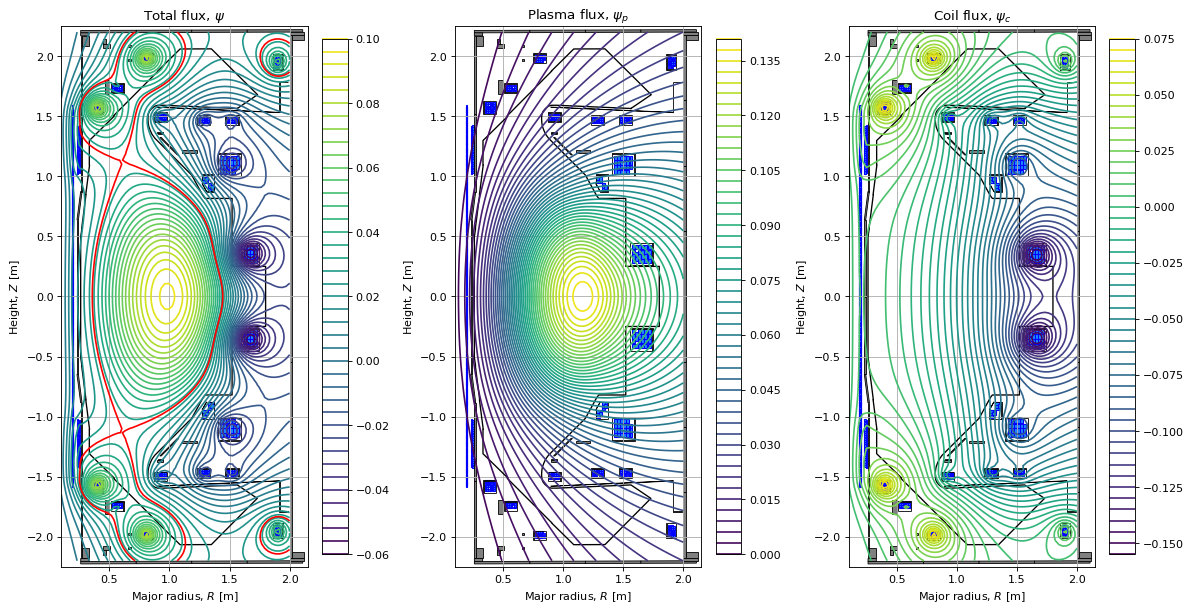

In [3]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.psi(), levels=50)                          # total psi
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')  # psi boundary contour
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"Total flux, $\psi$")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.plasma_psi, levels=50)                          # plasma psi
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"Plasma flux, $\psi_p$")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, eq.tokamak_psi, levels=50)                          # coil psi
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(r"Coil flux, $\psi_c$")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

#### Magnetic fields

Here, we plot the magnetic fields over the domain for each of the cylindrical coordinates. 

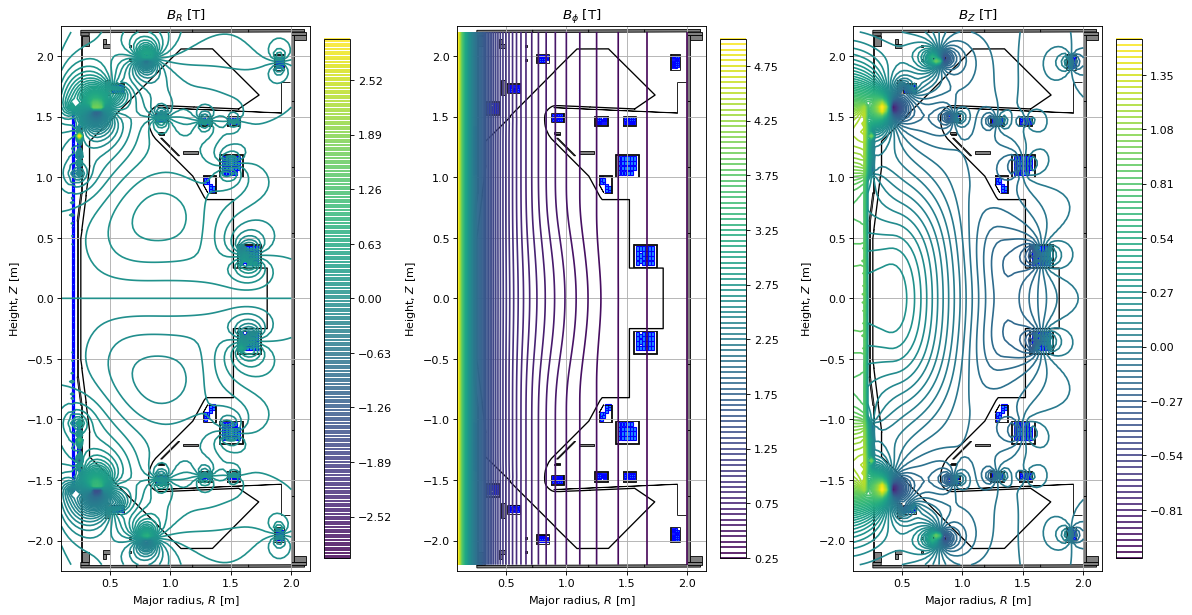

In [21]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.Br(eq.R, eq.Z), levels=200)                          # total psi
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.Btor(eq.R, eq.Z), levels=100)                          # plasma psi
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_{\phi}$ [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, eq.Bz(eq.R, eq.Z), levels=100)                          # coil psi
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(r"$B_Z$ [T]")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

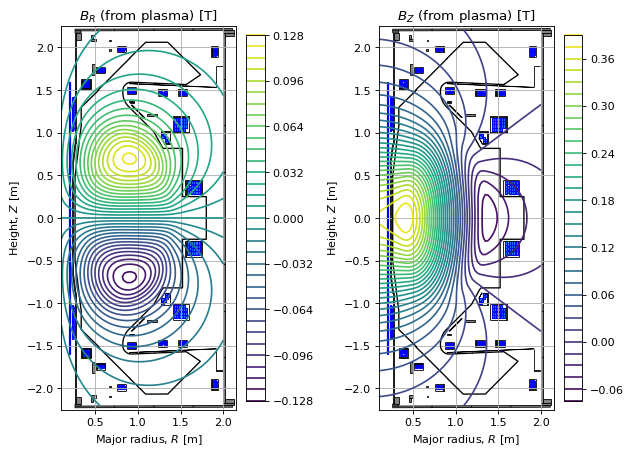

In [17]:
# this is just the contribution from the plasma
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.plasmaBr(eq.R, eq.Z), levels=30)                          # total psi
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ (from plasma) [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.plasmaBz(eq.R, eq.Z), levels=30)                          # plasma psi
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_Z$ (from plasma) [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


plt.tight_layout()

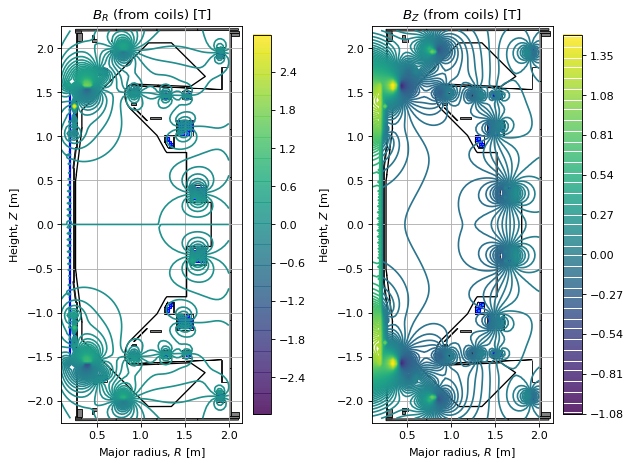

In [19]:
# this is just the contribution from the coils
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.tokamak.Br(eq.R, eq.Z), levels=200)                          # total psi
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ (from coils) [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.tokamak.Bz(eq.R, eq.Z), levels=200)                          # plasma psi
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_Z$ (from coils) [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


plt.tight_layout()

#### Coil currents

Here, we visualise the size of the currents in the poloidal field coils.

In [5]:
# listing the currents may not be that informative 
eq.tokamak.getCurrents()

{'Solenoid': 5000,
 'PX': 3439.334728468875,
 'D1': 9594.439971200029,
 'D2': -1259.3275754300903,
 'D3': 5893.482647983542,
 'Dp': -1998.5507259516799,
 'D5': 1415.6288076945568,
 'D6': -1636.135778750673,
 'D7': -817.2083027540341,
 'P4': -2248.675884575067,
 'P5': -4252.396507800862,
 'P6': -1.0681413427052806,
 'vessel_1': 0,
 'vessel_2': 0,
 'vessel_3': 0,
 'vessel_4': 0,
 'vessel_5': 0,
 'vessel_6': 0,
 'vessel_7': 0,
 'vessel_8': 0,
 'vessel_9': 0,
 'vessel_10': 0,
 'vessel_11': 0,
 'vessel_12': 0,
 'vessel_13': 0,
 'vessel_14': 0,
 'vessel_15': 0,
 'vessel_16': 0,
 'vessel_17': 0,
 'vessel_18': 0,
 'vessel_19': 0,
 'vessel_20': 0,
 'vessel_21': 0,
 'vessel_22': 0,
 'centrecolumn_1': 0,
 'centrecolumn_2': 0,
 'centrecolumn_3': 0,
 'centrecolumn_4': 0,
 'centrecolumn_5': 0,
 'centrecolumn_6': 0,
 'centrecolumn_7': 0,
 'centrecolumn_8': 0,
 'centrecolumn_9': 0,
 'centrecolumn_10': 0,
 'colosseum_upper_1': 0,
 'colosseum_upper_2': 0,
 'colosseum_upper_3': 0,
 'colosseum_lower_1': 0

You can play around with the colour schemes below to visualise how the current is distributed around the machine. Note here that there is no current in the passive structures but they can be included if present. 

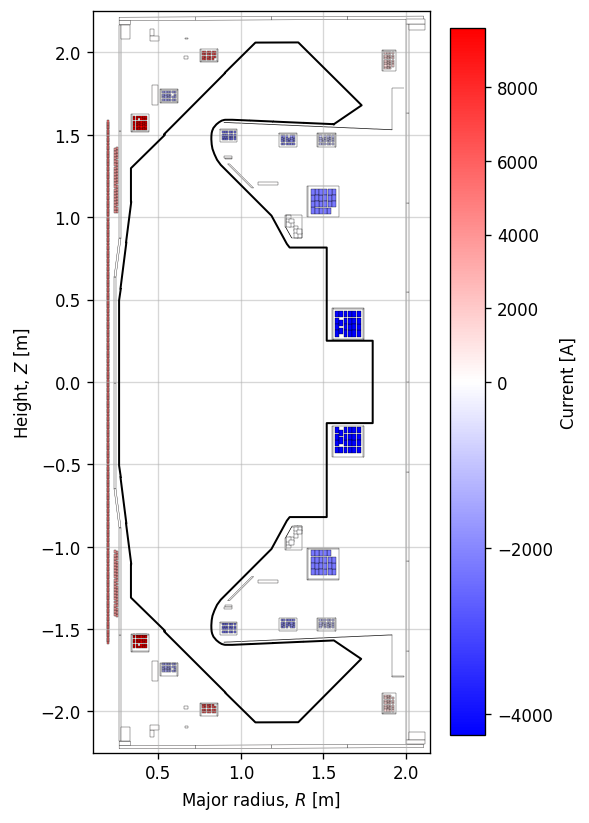

In [6]:
from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.cm as cm



# create colormap based on magnitude of currents
currents_array = []
for key in list(eq.tokamak.coils_dict.keys()):
    currents_array.append(eq.tokamak[key].current)

max_curr = np.max(np.abs(currents_array))
# norm = Normalize(vmin=-max_curr, vmax=max_curr) # alternative colorbar
norm = TwoSlopeNorm(vmin=np.min(currents_array), vcenter=0, vmax=np.max(currents_array))  
cmap = cm.bwr


# plot
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=120)
plt.tight_layout()
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')


for name in list(eq.tokamak.coils_dict.keys()):
    coil = eq.tokamak.coils_dict[name]
    current = eq.tokamak[name].current
    color = cmap(norm(current))  # map the current to a color
    
    # plot active coils (and currents)
    if coil["active"]:

        for i in range(0, len(coil["coords"][0,:])):
            patch = Rectangle(
                (coil["coords"][0,i] - coil["dR"] / 2, coil["coords"][1,i] - coil["dZ"] / 2),
                width=coil["dR"],
                height=coil["dZ"],
                facecolor=color,
                edgecolor='k',
                linewidth=0.2,
                )
            ax1.add_patch(patch)
    
    # plot passive structures (currents are zero here)        
    else:
        patch = Polygon(
            coil["vertices"].T, 
            facecolor=color, 
            edgecolor="k", 
            linewidth=0.2
        )
        ax1.add_patch(patch)


# add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = fig1.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.09)
cbar.set_label('Current [A]')

#### Plasma current density profiles (and others)
Here, we visualise the $p'$ and $FF'$ profiles used in our equilbirium solve. 

Text(0, 0.5, "$FF'(\\hat{\\psi})$")

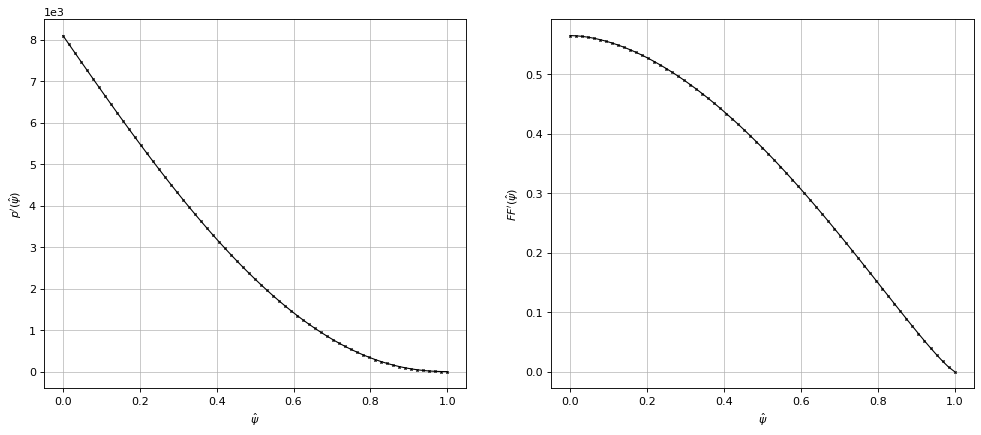

In [7]:
# plot the input p' and FF' profiles

psi_n = np.linspace(0,1,65)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, profiles.pressure(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p'(\hat{\psi})$")
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, profiles.ffprime(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$FF'(\hat{\psi})$")


Text(0, 0.5, '$q(\\hat{\\psi})$')

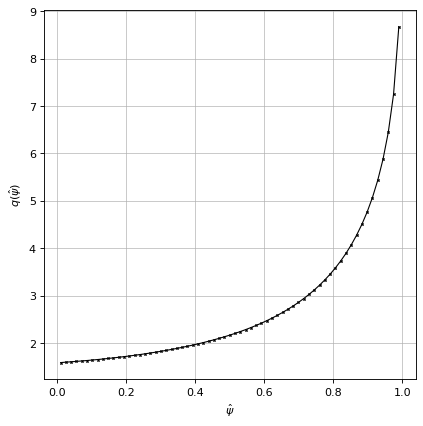

In [8]:
# plot q profile

psi_n = np.linspace(0.01,0.99,65)  # values of q at 0 and 1 can be problematic

fig1, ax1 = plt.subplots(1, 1, figsize=(6,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, eq.q(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$q(\hat{\psi})$")


Text(0, 0.5, '$fpol(\\hat{\\psi})$')

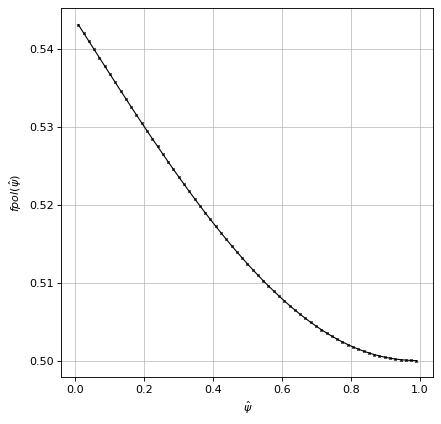

In [9]:
# plot fpol

fig1, ax1 = plt.subplots(1, 1, figsize=(6,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, eq.fpol(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$fpol(\hat{\psi})$")



#### Plasma current density

Here, we visualise the plasma current density inside the core of the plasma. 

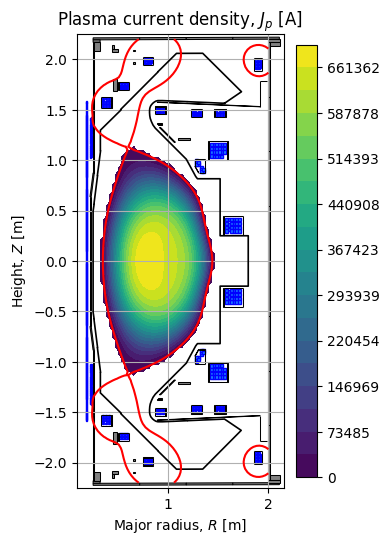

In [61]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=100)

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contourf(eq.R, eq.Z, eq._profiles.jtor, levels=np.linspace(0.01, np.max( eq._profiles.jtor,), 20))                        
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"Plasma current density, $J_p$ [A]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

plt.tight_layout()